In [1]:
import joblib
import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [2]:
df = pd.read_parquet('datasets/seisme/datasets_seisme.parquet')
X = df.drop(columns=['catastrophe', 'date'])
y = df['catastrophe']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
df['catastrophe'].unique()

array(['aucun', 'seisme'], dtype=object)

In [4]:
# define and fit a linear SVM model
linear_svc_model = svm.SVC(
    kernel='linear',
    C=0.01,                  # valeur optimisée par GridSearchCV
    class_weight='balanced',
    probability=True,
    random_state=42
)
linear_svc_model.fit(X_train, y_train)

# evaluate
print(f"Train accuracy: {linear_svc_model.score(X_train, y_train):.3f}")
print(f"Test accuracy:  {linear_svc_model.score(X_test, y_test):.3f}")

# detailed classification report
y_pred_linear = linear_svc_model.predict(X_test)
print(classification_report(y_test, y_pred_linear))


Train accuracy: 0.755
Test accuracy:  0.755
              precision    recall  f1-score   support

       aucun       0.89      0.71      0.79       279
      seisme       0.60      0.83      0.70       145

    accuracy                           0.75       424
   macro avg       0.75      0.77      0.75       424
weighted avg       0.79      0.75      0.76       424



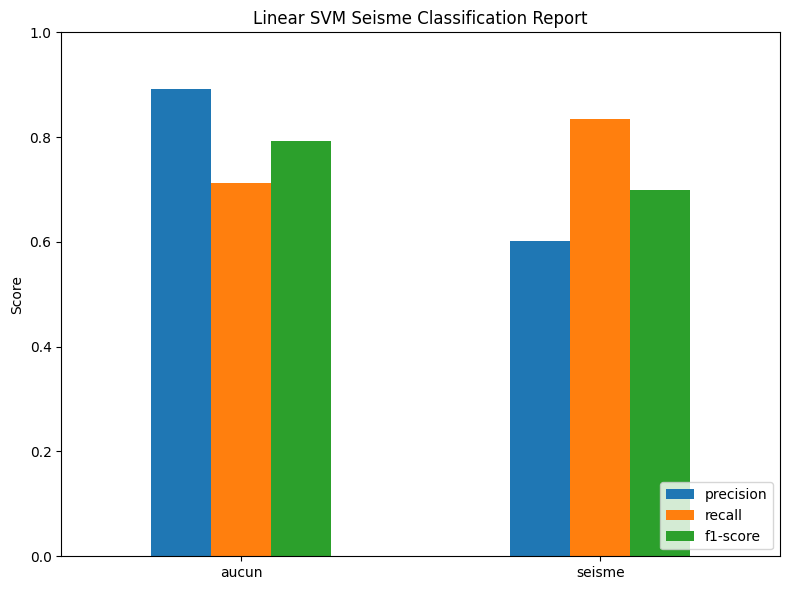

In [6]:
# plot classification report as a bar chart
report_dict = classification_report(y_test, y_pred_linear, output_dict=True)
df_report = pd.DataFrame(report_dict).T

# only keep the actual class rows (exclude accuracy, macro avg, weighted avg)
class_labels = [str(c) for c in linear_svc_model.classes_]
df_report = df_report.loc[class_labels, ['precision', 'recall', 'f1-score']]

# draw
fig, ax = plt.subplots(figsize=(8, 6))
df_report.plot(kind='bar', ax=ax)
plt.title("Linear SVM Seisme Classification Report")
plt.ylabel("Score")
plt.ylim(0, 1.0)
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

fig.savefig('./graph/Linear_classification_repport.png', dpi=300, bbox_inches='tight')

In [6]:
df = pd.read_parquet('datasets/inondation/datasets_inondation.parquet')
X = df.drop(columns=['catastrophe', 'date'])
y = df['catastrophe']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# define and fit a linear SVM model
linear_svc_model = svm.SVC(
    kernel='linear',
    class_weight='balanced',
    probability=True,
    random_state=42
)
linear_svc_model.fit(X_train, y_train)

# evaluate
print(f"Train accuracy: {linear_svc_model.score(X_train, y_train):.3f}")
print(f"Test accuracy:  {linear_svc_model.score(X_test, y_test):.3f}")

# detailed classification report
y_pred_linear = linear_svc_model.predict(X_test)
print(classification_report(y_test, y_pred_linear))

In [ ]:
# plot classification report as a bar chart
report_dict = classification_report(y_test, y_pred_linear, output_dict=True)
df_report = pd.DataFrame(report_dict).T

# only keep the actual class rows (exclude accuracy, macro avg, weighted avg)
class_labels = [str(c) for c in linear_svc_model.classes_]
df_report = df_report.loc[class_labels, ['precision', 'recall', 'f1-score']]

# draw
df_report.plot(kind='bar', figsize=(8, 6))
plt.title("Linear SVM Inondation Classification Report")
plt.ylabel("Score")
plt.ylim(0, 1.0)
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [ ]:
df = pd.read_csv('./dataset.csv')
X = df.drop(columns=['catastrophe', 'date', 'force_du_vecteur_de_vent_max'])
y = df['catastrophe']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# define and fit a linear SVM model
linear_svc_model = svm.SVC(
    kernel='linear',
    class_weight='balanced',
    C=0.01,                  # valeur optimisée par GridSearchCV
    probability=True,
    random_state=42
)
linear_svc_model.fit(X_train, y_train)

# evaluate
print(f"Train accuracy: {linear_svc_model.score(X_train, y_train):.3f}")
print(f"Test accuracy:  {linear_svc_model.score(X_test, y_test):.3f}")

# detailed classification report
y_pred_linear = linear_svc_model.predict(X_test)
print(classification_report(y_test, y_pred_linear))


In [7]:
#Charger le dataset
df = pd.read_csv('./dataset.csv')

#Encoder la cible en 4 classes multi-classe
mapping = {
    'aucun': 0,
    "['innondation']": 1,
    "['seisme']": 2,
    "['innondation', 'seisme']": 3
}
df['cat_code'] = df['catastrophe'].map(mapping)

y = df['cat_code']
X = df.drop(columns=['catastrophe', 'date', 'cat_code','force_du_vecteur_de_vent_max','temperature','humidite','force_moyenne_du_vecteur_de_vent'])

#Séparation des features catégorielles et numériques
cat_feats = ['quartier']
num_feats = [c for c in X.columns if c not in cat_feats]

#Préprocesseur
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_feats),
    ('num', 'passthrough', num_feats)
])

#Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

#Prétraitement
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

#XGBoost
# calculer les poids de classes
classes = np.unique(y_train)
cw = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, cw))

xgb_clf = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=4,
    n_estimators=1000,
    learning_rate=0.001,
    use_label_encoder=False,
    class_weight=class_weights,
    eval_metric='mlogloss',
    verbosity=1,
    random_state=42
)

# préparer sample_weight pour le fit
sample_weight = y_train.map(class_weights)
print("=== Training XGBoost ===")
xgb_clf.fit(
    X_train_proc,
    y_train,
    eval_set=[(X_test_proc, y_test)],
)

# 7. LightGBM
lgb_clf = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=4,
    n_estimators=1000,
    learning_rate=0.001,
    class_weight=class_weights,
    random_state=42,
    verbosity=1,
)
print("=== Training LightGBM ===")
lgb_clf.fit(
    X_train_proc,
    y_train,
    eval_set=[(X_test_proc, y_test)],
    eval_metric='multi_logloss',
)

# 8. Sauvegarde des modèles et du préprocesseur
joblib.dump(preprocessor, 'preprocessor.pkl')
xgb_clf.save_model('xgb_model.json')
lgb_clf.booster_.save_model('lgbm_model.txt')
joblib.dump(lgb_clf, 'lgbm_pipeline.pkl')
print("\nSaved: preprocessor.pkl, xgb_model.json, lgbm_model.txt, lgbm_pipeline.pkl")

=== Training XGBoost ===
[0]	validation_0-mlogloss:1.38520
[1]	validation_0-mlogloss:1.38410
[2]	validation_0-mlogloss:1.38300
[3]	validation_0-mlogloss:1.38191
[4]	validation_0-mlogloss:1.38082
[5]	validation_0-mlogloss:1.37973
[6]	validation_0-mlogloss:1.37864
[7]	validation_0-mlogloss:1.37756
[8]	validation_0-mlogloss:1.37648
[9]	validation_0-mlogloss:1.37540
[10]	validation_0-mlogloss:1.37432
[11]	validation_0-mlogloss:1.37324
[12]	validation_0-mlogloss:1.37217
[13]	validation_0-mlogloss:1.37110
[14]	validation_0-mlogloss:1.37003
[15]	validation_0-mlogloss:1.36896
[16]	validation_0-mlogloss:1.36789
[17]	validation_0-mlogloss:1.36682
[18]	validation_0-mlogloss:1.36576
[19]	validation_0-mlogloss:1.36470
[20]	validation_0-mlogloss:1.36364
[21]	validation_0-mlogloss:1.36258
[22]	validation_0-mlogloss:1.36153


/Users/valentin/Documents/Ynov/terra-vigilance-predict-api/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:53:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "class_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[23]	validation_0-mlogloss:1.36048
[24]	validation_0-mlogloss:1.35943
[25]	validation_0-mlogloss:1.35838
[26]	validation_0-mlogloss:1.35734
[27]	validation_0-mlogloss:1.35629
[28]	validation_0-mlogloss:1.35525
[29]	validation_0-mlogloss:1.35421
[30]	validation_0-mlogloss:1.35318
[31]	validation_0-mlogloss:1.35214
[32]	validation_0-mlogloss:1.35110
[33]	validation_0-mlogloss:1.35007
[34]	validation_0-mlogloss:1.34904
[35]	validation_0-mlogloss:1.34801
[36]	validation_0-mlogloss:1.34699
[37]	validation_0-mlogloss:1.34596
[38]	validation_0-mlogloss:1.34494
[39]	validation_0-mlogloss:1.34392
[40]	validation_0-mlogloss:1.34290
[41]	validation_0-mlogloss:1.34189
[42]	validation_0-mlogloss:1.34087
[43]	validation_0-mlogloss:1.33986
[44]	validation_0-mlogloss:1.33884
[45]	validation_0-mlogloss:1.33784
[46]	validation_0-mlogloss:1.33682
[47]	validation_0-mlogloss:1.33582
[48]	validation_0-mlogloss:1.33481
[49]	validation_0-mlogloss:1.33381
[50]	validation_0-mlogloss:1.33280
[51]	validation_0-ml

In [8]:
# 9. Évaluation des performances
print("\n=== Évaluation XGBoost ===")
y_pred_xgb = xgb_clf.predict(X_test_proc)
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"Precision (macro): {precision_score(y_test, y_pred_xgb, average='macro'):.4f}")
print(f"Recall (macro): {recall_score(y_test, y_pred_xgb, average='macro'):.4f}")

print("\n=== Évaluation LightGBM ===")
y_pred_lgb = lgb_clf.predict(X_test_proc)
print(f"Accuracy: {accuracy_score(y_test, y_pred_lgb):.4f}")
print(f"Precision (macro): {precision_score(y_test, y_pred_lgb, average='macro'):.4f}")
print(f"Recall (macro): {recall_score(y_test, y_pred_lgb, average='macro'):.4f}")


=== Évaluation XGBoost ===
Accuracy: 0.7747
Precision (macro): 0.7579
Recall (macro): 0.8390

=== Évaluation LightGBM ===
Accuracy: 0.7806
Precision (macro): 0.7675
Recall (macro): 0.8520


/Users/valentin/Documents/Ynov/terra-vigilance-predict-api/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


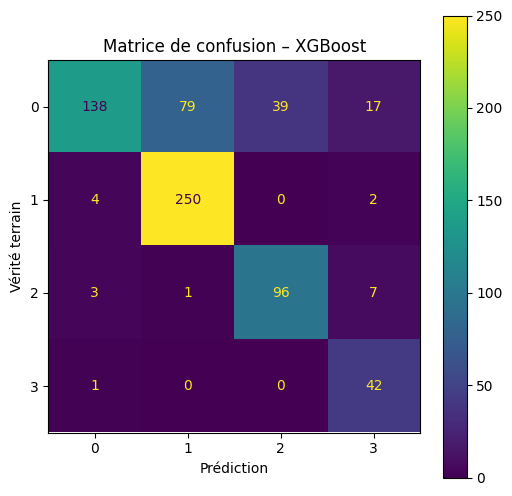

In [9]:
# 1. Calcul de la matrice de confusion
cm = confusion_matrix(y_test, y_pred_xgb, labels=xgb_clf.classes_)

# 2. Affichage avec sklearn
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=xgb_clf.classes_)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax)
plt.title("Matrice de confusion – XGBoost")
plt.xlabel("Prédiction")
plt.ylabel("Vérité terrain")
plt.show()
fig.savefig('./graph/confusion_matrix_xgboost.png', dpi=300, bbox_inches='tight')

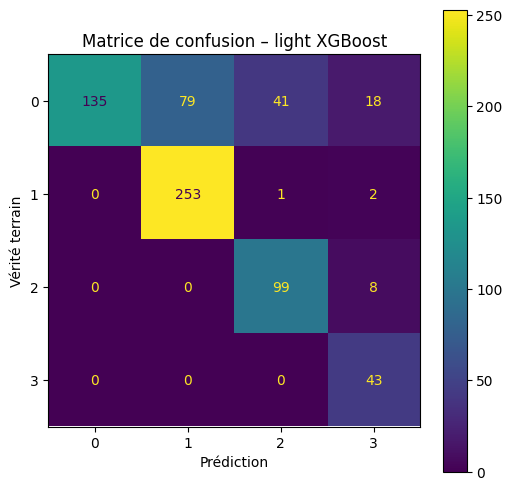

In [10]:
# 1. Calcul de la matrice de confusion
cm = confusion_matrix(y_test, y_pred_lgb, labels=lgb_clf.classes_)

# 2. Affichage avec sklearn
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=lgb_clf.classes_)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax)
plt.title("Matrice de confusion – light XGBoost")
plt.xlabel("Prédiction")
plt.ylabel("Vérité terrain")
plt.show()

fig.savefig('./graph/confusion_matrix_lgb.png', dpi=300, bbox_inches='tight')